This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Production of a maximum reflectivity composite

In [1]:
import os
import numpy as np
import wradlib
import xarray
import xradar
import matplotlib.pyplot as plt

Read volume reflectivity measurements from the three belgian radars

In [2]:
from wradlib_data import DATASETS

filenames = ["bejab.pvol.hdf", "bewid.pvol.hdf", "behel.pvol.hdf"]
paths = [DATASETS.fetch(f"hdf5/{f}") for f in filenames]
volumes = [xradar.io.backends.odim.open_odim_datatree(p) for p in paths]

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  subgroup = xr.merge([ds[extract_vars] for ds in ls_ds])
/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or s

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  subgroup = xr.merge([ds[extract_vars] for ds in ls_ds])
/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or s

Define a raster dataset with a window including the 3 radars, a pixel size of 1km and the standard European projection.

In [3]:
crs = wradlib.georef.epsg_to_osr(3035)
bounds = [0, 8, 48, 53]
bounds = wradlib.georef.project_bounds(bounds, crs)
print(bounds)
size = 1000
raster = wradlib.georef.create_raster_xarray(crs, bounds, size)

(np.float64(3614003.511103494), np.float64(4179113.3018474784), np.float64(2783335.3563101026), np.float64(3337903.626233562))


Define a geographic raster dataset with a window including the 3 radars, and an approximate pixel size of 1km. 

In [4]:
crs = wradlib.georef.epsg_to_osr(3035)
bounds = [0, 8, 48, 53]
size = 1000
raster2 = wradlib.georef.create_raster_geographic(bounds, size, size_in_meters=True)

Combine lowest radar sweep into a raster image for each radar

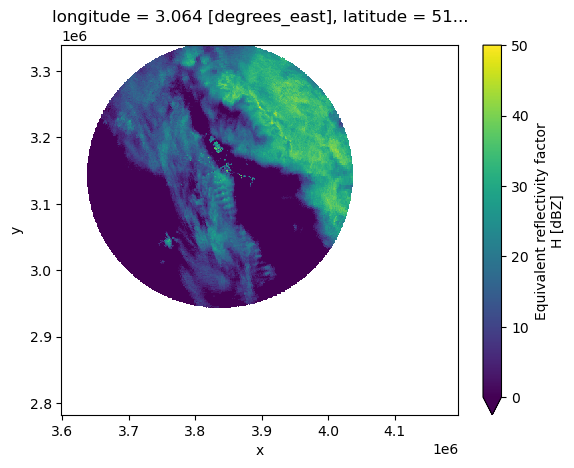

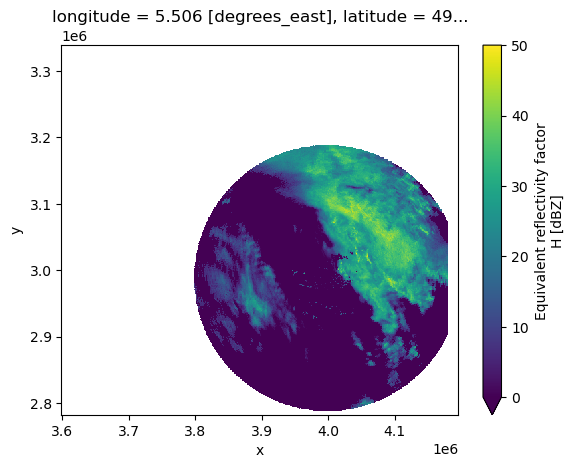

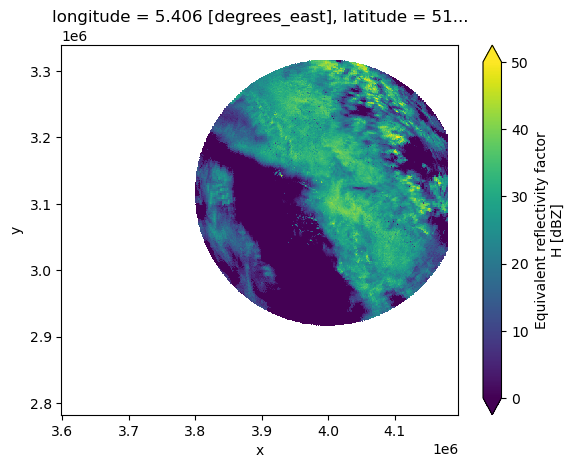

In [5]:
# raster = raster2
metadata = xradar.model.required_sweep_metadata_vars
rasters = []
for volume in volumes:
    sweep = volume["sweep_0"].to_dataset()
    sweep = sweep[["DBZH"] + list(metadata)]
    sweep = sweep.sel(range=slice(0, 200e3))
    raster_sweep = wradlib.comp.sweep_to_raster(sweep, raster)
    rasters.append(raster_sweep)

for raster in rasters:
    raster = raster.drop_vars("spatial_ref")
    raster["DBZH"].plot(vmin=0, vmax=50)
    plt.axis("equal")
    plt.show()

Take the maximum value from the 3 rasters

Driver: netCDF/Network Common Data Format
Files: comp.nc
Size is 567, 556
Metadata:
  DBZH#coordinates=spatial_ref
  DBZH#long_name=Equivalent reflectivity factor H
  DBZH#standard_name=radar_equivalent_reflectivity_factor_h
  DBZH#units=dBZ
  DBZH#_FillValue=nan
  DBZH#_Undetect=0
  x#_FillValue=nan
  y#_FillValue=nan
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  556.0)
Upper Right (  567.0,    0.0)
Lower Right (  567.0,  556.0)
Center      (  283.5,  278.0)
Band 1 Block=567x1 Type=Float64, ColorInterp=Undefined
  NoData Value=nan
  Unit Type: dBZ
  Metadata:
    NETCDF_VARNAME=DBZH
    _FillValue=nan
    _Undetect=0
    long_name=Equivalent reflectivity factor H
    units=dBZ
    standard_name=radar_equivalent_reflectivity_factor_h
    coordinates=spatial_ref


/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


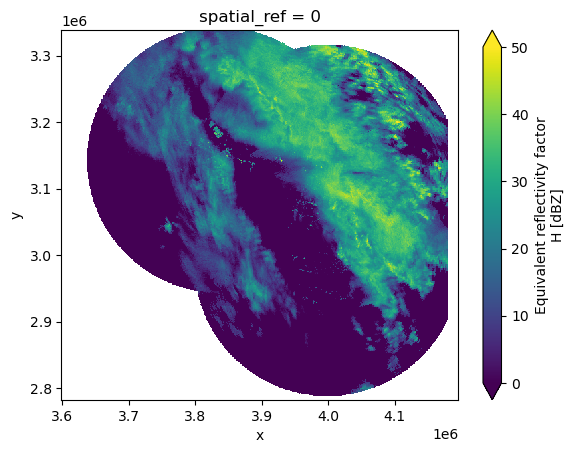

In [6]:
rasters_concat = xarray.concat(rasters, dim="sweep")
comp = rasters_concat.max(dim="sweep", keep_attrs=True)
comp["DBZH"].plot(vmin=0, vmax=50)
with open("comp.nc", "wb") as f:
    comp.to_netcdf(f)
!gdalinfo comp.nc
ds = xarray.open_dataset("comp.nc", engine="rasterio")
comp = comp.drop_vars("spatial_ref")
plt.axis("equal")
plt.show()